Epoch [1/20], Train Acc: 91.56%, Val Acc: 92.62%, Train Loss: 0.2629, Val Loss: 0.2225
Epoch [2/20], Train Acc: 97.11%, Val Acc: 97.87%, Train Loss: 0.0946, Val Loss: 0.0634
Epoch [3/20], Train Acc: 97.75%, Val Acc: 97.26%, Train Loss: 0.0718, Val Loss: 0.0808
Epoch [4/20], Train Acc: 98.02%, Val Acc: 97.94%, Train Loss: 0.0633, Val Loss: 0.0625
Epoch [5/20], Train Acc: 98.23%, Val Acc: 97.87%, Train Loss: 0.0560, Val Loss: 0.0672
Epoch [6/20], Train Acc: 98.43%, Val Acc: 98.52%, Train Loss: 0.0516, Val Loss: 0.0472
Epoch [7/20], Train Acc: 98.47%, Val Acc: 98.53%, Train Loss: 0.0479, Val Loss: 0.0416
Epoch [8/20], Train Acc: 98.64%, Val Acc: 98.65%, Train Loss: 0.0438, Val Loss: 0.0432
Epoch [9/20], Train Acc: 98.70%, Val Acc: 98.67%, Train Loss: 0.0414, Val Loss: 0.0374
Epoch [10/20], Train Acc: 98.81%, Val Acc: 98.87%, Train Loss: 0.0371, Val Loss: 0.0338
Epoch [11/20], Train Acc: 98.92%, Val Acc: 98.93%, Train Loss: 0.0344, Val Loss: 0.0305
Epoch [12/20], Train Acc: 98.97%, Val Acc

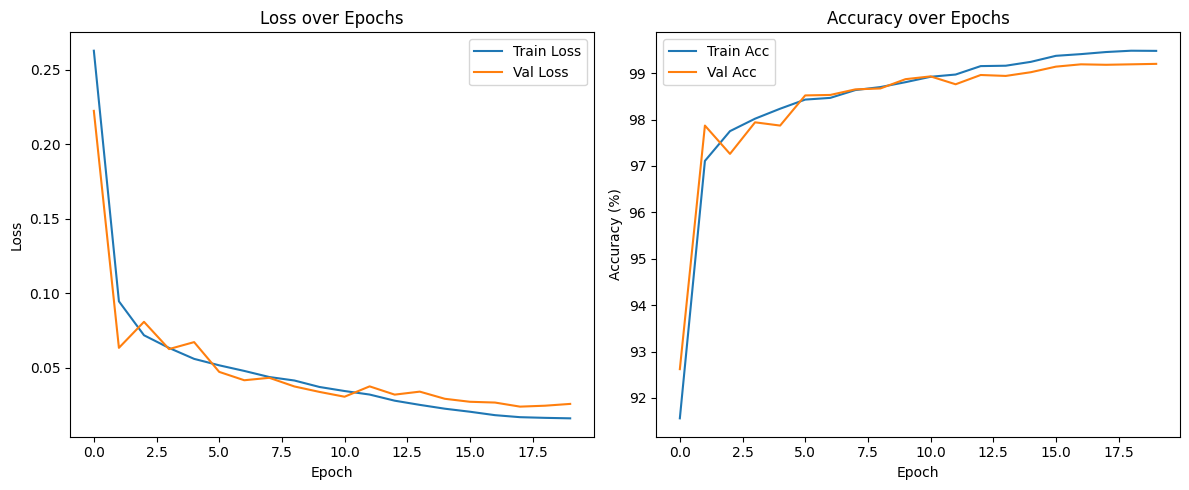

Training completed in 653.03 seconds.


In [ ]:
# MNIST Training with 9-Layer CNN-style and Custom Initializations (Optimized)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 0.001

# MNIST dataset (1 channel, 28x28 grayscale images)
transform = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Custom hybrid initialization: He for shallow, Orthogonal for deep
def custom_init(model):
    relu_gain = nn.init.calculate_gain('relu')
    layer_idx = 0
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if layer_idx < 6:
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            else:
                nn.init.orthogonal_(m.weight, gain=relu_gain)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
            layer_idx += 1

# 9-Layer CNN (adapted for MNIST input size and 1 channel)
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 3 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

# Training function with scheduler
def train_model(model):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        correct, total, train_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss / len(train_loader))

        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss / len(test_loader))

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Train Loss: {train_loss_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}")

    duration = time.time() - start_time
    return train_acc_list, val_acc_list, train_loss_list, val_loss_list, duration

# Main training routine
model = MNISTCNN()
custom_init(model)
train_acc, val_acc, train_loss, val_loss, time_taken = train_model(model)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Training completed in {time_taken:.2f} seconds.")
